### **Detection and Classification of Cardiac Arrhythmias from ECG Signals**

### Fundamentals of Intelligent Systems final project

#Downloading the dataset

In [39]:
!pip install gdown

In [40]:
!gdown 1jndKYtmHxRq1I7wNeKXuEQ7t0WYukfyu -O mitbih_database.zip
!unzip mitbih_database.zip -d mitbih_database

Downloading...
From (original): https://drive.google.com/uc?id=1jndKYtmHxRq1I7wNeKXuEQ7t0WYukfyu
From (redirected): https://drive.google.com/uc?id=1jndKYtmHxRq1I7wNeKXuEQ7t0WYukfyu&confirm=t&uuid=7aa87cc8-76ac-430f-b0de-bfdc45562ddd
To: /content/mitbih_database.zip
100% 149M/149M [00:01<00:00, 80.5MB/s]
Archive:  mitbih_database.zip
replace mitbih_database/mitbih_database/223annotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mitbih_database/mitbih_database/223annotations.txt  
  inflating: mitbih_database/mitbih_database/222annotations.txt  
  inflating: mitbih_database/mitbih_database/232annotations.txt  
  inflating: mitbih_database/mitbih_database/234annotations.txt  
  inflating: mitbih_database/mitbih_database/228annotations.txt  
  inflating: mitbih_database/mitbih_database/221annotations.txt  
  inflating: mitbih_database/mitbih_database/219annotations.txt  
  inflating: mitbih_database/mitbih_database/231annotations.txt  
  inflating: mitbih_database/mitbih_d

Main Imports

In [41]:
import os
import csv
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

#Loading the dataset

In [42]:
# Set dataset path
path = "/content/mitbih_database/mitbih_database/"

Dataset setup

In [43]:
# Get filenames from dataset directory
filenames = next(os.walk(path))[2]  # Get list of files

records = []
annotations = []
filenames.sort()

# Separate records and annotation files
for name in filenames:
    filename, file_extension = os.path.splitext(name)
    if file_extension == '.csv':
        records.append(path + filename + file_extension)
    if file_extension == '.txt':
        annotations.append(path + filename + file_extension)

print("records (files 1 to 3):", records[0:3])
print("annotations (files 1 to 3):", annotations[0:3])

records (files 1 to 3): ['/content/mitbih_database/mitbih_database/100.csv', '/content/mitbih_database/mitbih_database/101.csv', '/content/mitbih_database/mitbih_database/102.csv']
annotations (files 1 to 3): ['/content/mitbih_database/mitbih_database/100annotations.txt', '/content/mitbih_database/mitbih_database/101annotations.txt', '/content/mitbih_database/mitbih_database/102annotations.txt']


Noise Removal & Normalization Functions

Imports

In [44]:
import scipy.signal as signal
from scipy.signal import iirnotch, filtfilt
from scipy import stats

In [45]:
def smooth_ecg(ecg_signal, window_size=10, fs=360):
    kernel = np.ones(window_size) / window_size
    denoised_signal = np.convolve(ecg_signal, kernel, mode='same')
    return denoised_signal

def notch_filter60Hz_ecg(ecg_signal, notch_freq=60, fs=360, quality_factor=30):
    # Design Notch filter
    w0 = notch_freq / (fs / 2)  # Normalize frequency
    b, a = iirnotch(w0, quality_factor)
    # Apply the Notch filter
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def notch_filter30Hz_ecg(ecg_signal, notch_freq=30, fs=360, quality_factor=30):
    # Design Notch filter
    w0 = notch_freq / (fs / 2)  # Normalize frequency
    b, a = iirnotch(w0, quality_factor)
    # Apply the Notch filter
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

def Remove_Noise(ecg_signal):
    Removed_60Hz = notch_filter60Hz_ecg(ecg_signal)
    Removed_30and30Hz = notch_filter30Hz_ecg(Removed_60Hz)
    Smoothed = smooth_ecg(Removed_30and30Hz)
    return Smoothed

def z_score_normalize(ecg_signal):
    ecg_signal = np.array(ecg_signal)
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    normalized_signal = (ecg_signal - mean) / std
    return normalized_signal


#Dataset Samples


Annotation sample

In [46]:
annotation_file = annotations[0]  # Pick the first annotation file
with open(annotation_file, 'r') as file:
    for _ in range(10):  # Print first 10 lines
        print(file.readline().strip())

Time   Sample #  Type  Sub Chan  Num	Aux
0:00.050       18     +    0    0    0	(N
0:00.214       77     N    0    0    0
0:01.028      370     N    0    0    0
0:01.839      662     N    0    0    0
0:02.628      946     N    0    0    0
0:03.419     1231     N    0    0    0
0:04.208     1515     N    0    0    0
0:05.025     1809     N    0    0    0
0:05.678     2044     A    0    0    0


Recording sample & Noise removal & Normalization

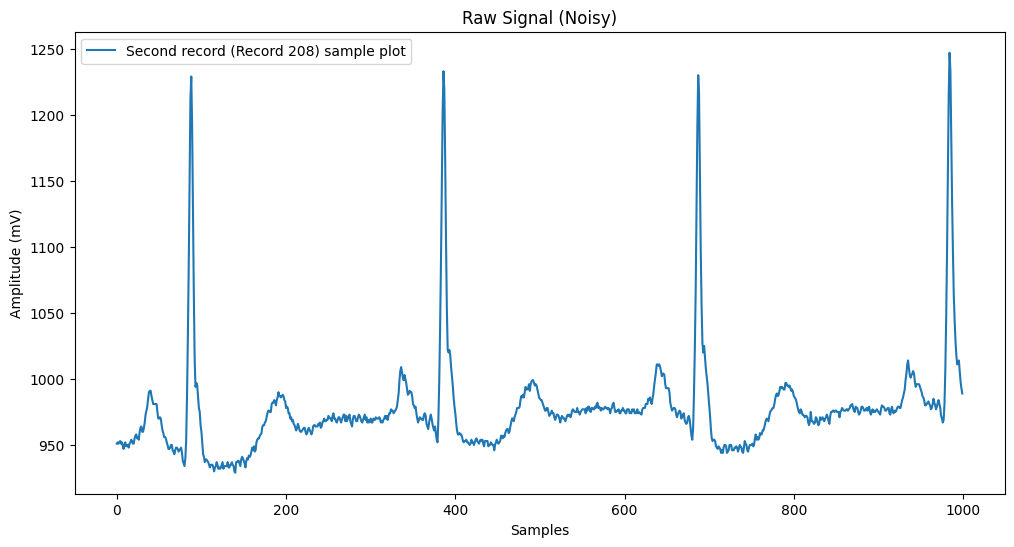

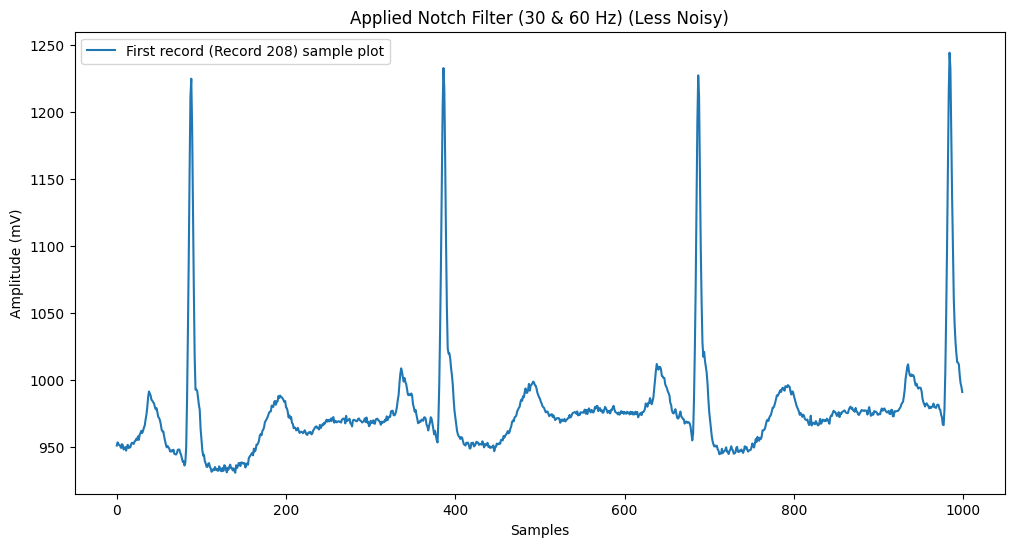

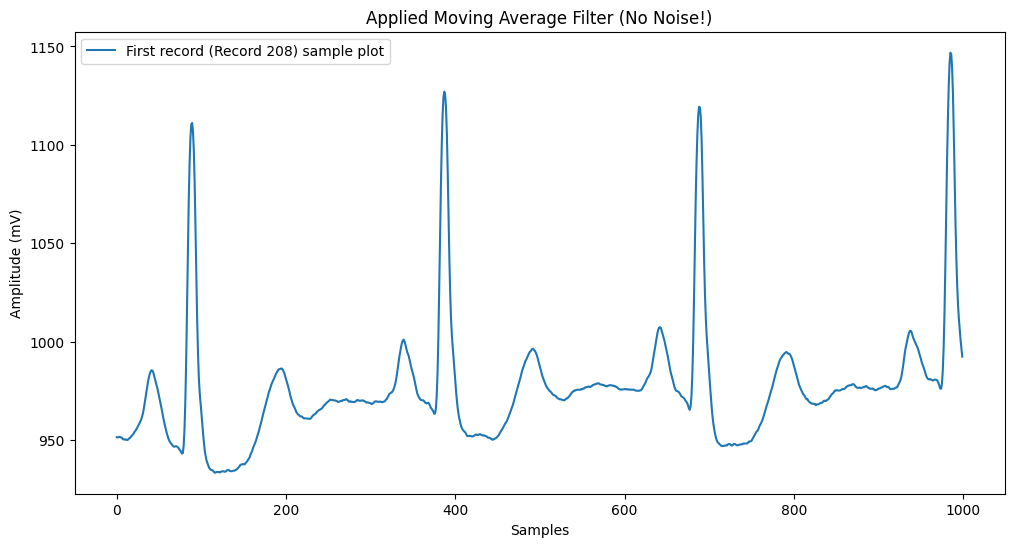

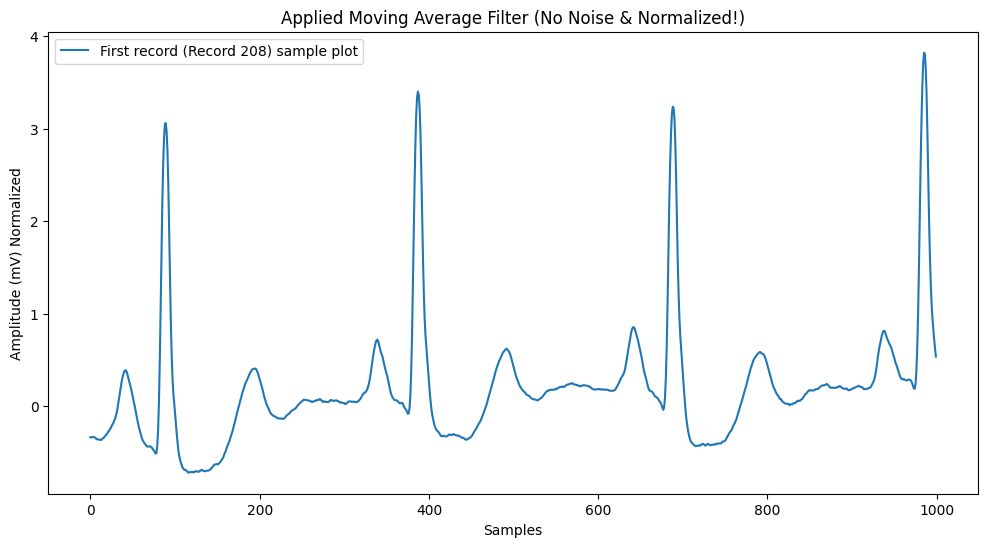

In [47]:
samples = []

with open(records[1], 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')  # Read CSV file
    row_index = -1
    for row in reader:
        if row_index >= 0:
            samples.append(int(row[1]))  # Second column contains the lead data
        row_index += 1

notched_60Hz_samples = notch_filter60Hz_ecg(samples)
notched_60and30Hz_samples = notch_filter60Hz_ecg(notched_60Hz_samples)
smooth_samples = smooth_ecg(notched_60and30Hz_samples)
Normallized_samples = z_score_normalize(smooth_samples)

plt.figure(figsize=(12, 6))
plt.plot(samples[30000:31000], label=f"Second record (Record 208) sample plot")
plt.title(f"Raw Signal (Noisy)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(notched_60and30Hz_samples[30000:31000], label=f"First record (Record 208) sample plot")
plt.title(f"Applied Notch Filter (30 & 60 Hz) (Less Noisy)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(smooth_samples[30000:31000], label=f"First record (Record 208) sample plot")
plt.title(f"Applied Moving Average Filter (No Noise!)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(Normallized_samples[30000:31000], label=f"First record (Record 208) sample plot")
plt.title(f"Applied Moving Average Filter (No Noise & Normalized!)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV) Normalized")
plt.legend()
plt.show()



#Pre Processing

Dataset Preparation: Noise removal & Normalizing

In [48]:
# Define parameters
beat_size_afterR = 160
beat_size_beforeR = 90
fs = 360  # Sampling frequency (Hz)

# ECG beat classes
classes = ['N', 'V', 'A', 'L', 'R', 'F']
#Normal | Premature Ventricular Contraction | Premature Atrial Contraction | Left Bundle Branch Block | Right Bundle Branch Block | Beat Fusion
n_classes = len(classes)
count_classes = [0] * len(classes)


X = list()
y = list()

# Process each ECG record
for r in range(len(records)):  # Iterate over all records
    signals = []

    # Read ECG signal from CSV file
    with open(records[r], 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')  # Read CSV file
        row_index = -1
        for row in reader:
            if row_index >= 0:
                signals.append(int(row[1]))  # Second column contains the lead data
            row_index += 1

    # Remove ECG signal Noise
    signals = Remove_Noise(signals)
    # Normalize signal using z-score
    signals = z_score_normalize(signals)

    # Extract beats based on annotations
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        for d in range(1, len(data)):  # Skip header
            splitted_anotation = data[d].split()  # Split by whitespace
            if len(splitted_anotation) < 3:
                continue  # Skip invalid lines
            pos = int(splitted_anotation[1])  # Extract Sample Index directly
            arrhythmia_type = splitted_anotation[2]  # Extract Arrhythmia label

            if arrhythmia_type in classes:  # Check if beat type is relevant
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1  # Count beats per class

                if beat_size_afterR <= pos < (len(signals) - beat_size_afterR):
                    beat = signals[pos - beat_size_beforeR: pos + beat_size_afterR]  # Extract beat

                    X.append(beat)
                    y.append(arrhythmia_index)

# Print dataset shape
print("Dataset Shape:", np.shape(X), np.shape(y))  # Dataset of all beats and their labeled arrhythmias

Dataset Shape: (100818, 250) (100818,)


Sample

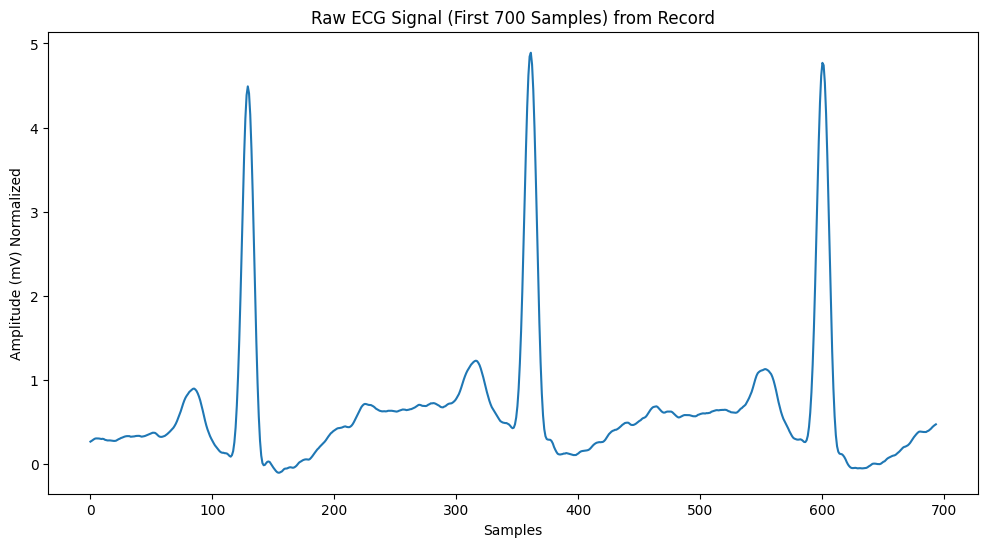

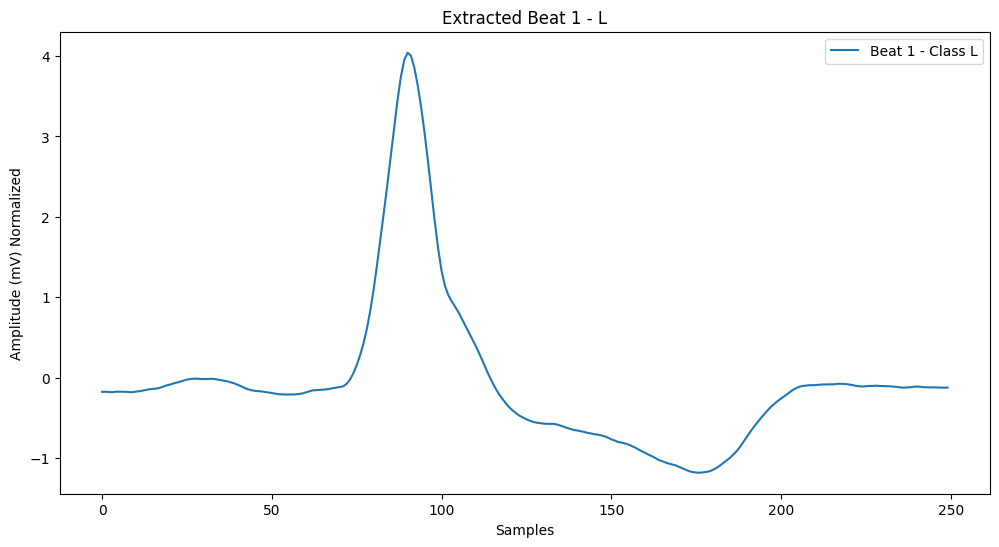

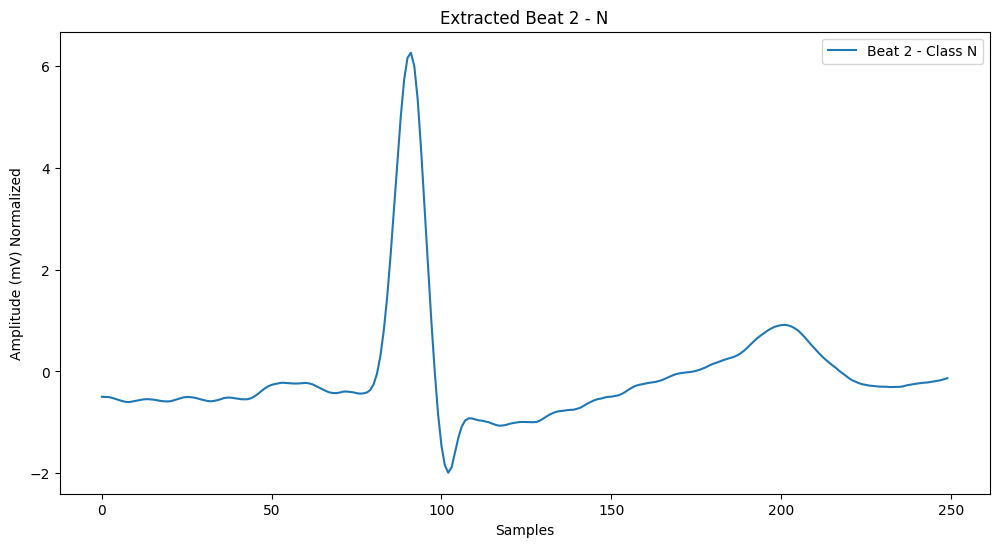

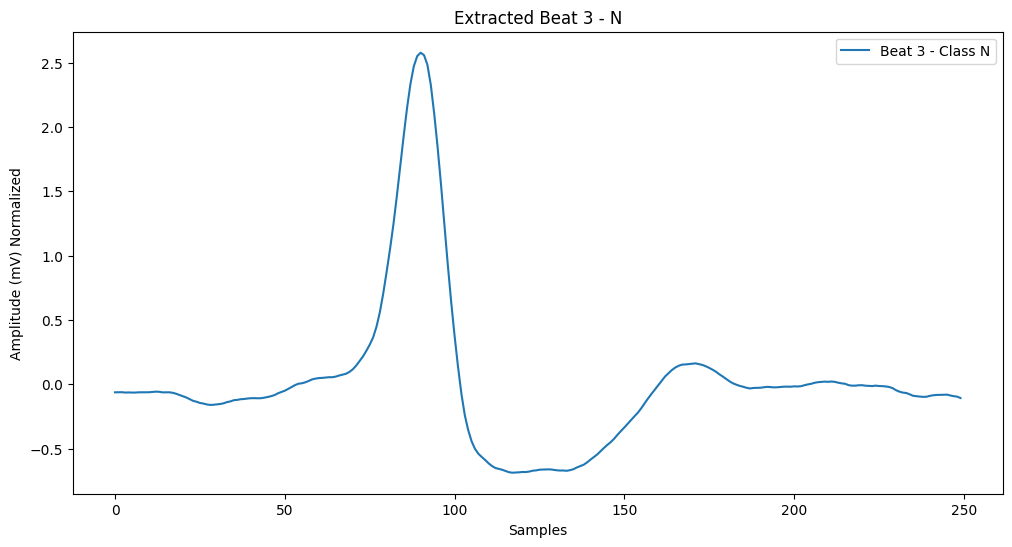

Arrhythmia Type: N, Count: 75052
Arrhythmia Type: V, Count: 7130
Arrhythmia Type: A, Count: 2546
Arrhythmia Type: L, Count: 8075
Arrhythmia Type: R, Count: 7259
Arrhythmia Type: F, Count: 803


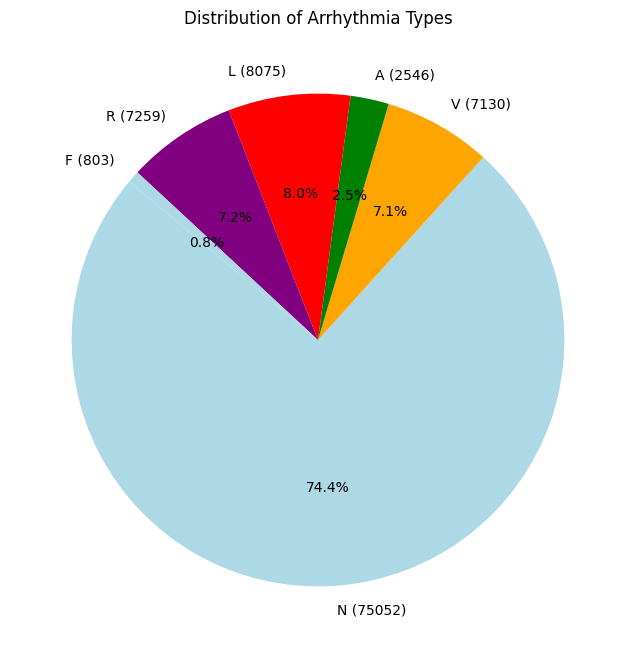

In [49]:
# Set the number of beats to visualize
num_visualizations = 3  # Choose how many beats you want to visualize

# Plot some raw ECG signals (first few samples from the dataset)
plt.figure(figsize=(12, 6))
plt.title("Raw ECG Signal (First 700 Samples) from Record")
plt.plot(signals[6:700])  # Plot the first 700 samples from the signal
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV) Normalized")
plt.show()

# Plot some individual beats from the dataset (extracted beats from X)
for i in range(num_visualizations):
    idx = random.randint(0, len(X) - 1)  # Randomly select an index from the extracted beats
    beat = X[idx]
    label = y[idx]

    plt.figure(figsize=(12, 6))
    plt.plot(beat, label=f"Beat {i+1} - Class {classes[label]}")
    plt.title(f"Extracted Beat {i+1} - {classes[label]}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV) Normalized")
    plt.legend()
    plt.show()


# Visualize the distribution of arrhythmia types using a pie chart with counts and print the values
arrhythmia_counts = np.array(count_classes)

# Print the counts
for cls, cnt in zip(classes, arrhythmia_counts):
    print(f"Arrhythmia Type: {cls}, Count: {cnt}")

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(arrhythmia_counts, labels=[f"{cls} ({cnt})" for cls, cnt in zip(classes, arrhythmia_counts)],
        autopct='%1.1f%%', colors=['lightblue', 'orange', 'green', 'red', 'purple'], startangle=140)
plt.title("Distribution of Arrhythmia Types")
plt.show()


Balancing the dataset

In [50]:
from sklearn.utils import resample

Arrhythmia Type: N, Count: 5000
Arrhythmia Type: V, Count: 5000
Arrhythmia Type: A, Count: 5000
Arrhythmia Type: L, Count: 5000
Arrhythmia Type: R, Count: 5000
Arrhythmia Type: F, Count: 5000


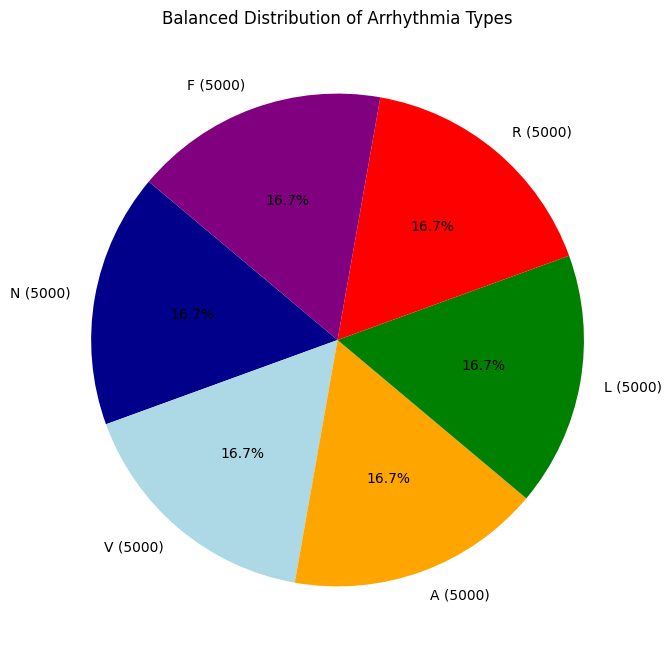

In [51]:
# Convert lists to numpy arrays for easier processing
X = np.array(X, dtype=object)
y = np.array(y)

# Target count for balance
target_count = 5000

# Initialize lists for balanced data
X_balanced = []
y_balanced = []

# Balance each class
for cls in range(len(classes)):
    # Get indices of samples for the current class
    class_indices = np.where(y == cls)[0]
    class_samples = X[class_indices]

    if len(class_samples) > target_count:
        # **Undersampling**: Reduce class to 5000 samples
        balanced_samples = resample(class_samples, replace=False, n_samples=target_count, random_state=42)
    else:
        # **Oversampling**: Increase class to 5000 samples
        balanced_samples = resample(class_samples, replace=True, n_samples=target_count, random_state=42)

    # Store balanced data
    X_balanced.extend(balanced_samples)
    y_balanced.extend([cls] * target_count)

# Convert to numpy arrays
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

# Compute the new balanced class distribution
balanced_counts = {}
for idx, cls in enumerate(classes):
    balanced_counts[cls] = (y_balanced == idx).sum()

# Print the balanced counts
for cls, count in balanced_counts.items():
    print(f"Arrhythmia Type: {cls}, Count: {count}")

# Create a pie chart for visualization
plt.figure(figsize=(8, 8))
plt.pie(balanced_counts.values(), labels=[f"{cls} ({count})" for cls, count in balanced_counts.items()],
        autopct='%1.1f%%', colors=['darkblue', 'lightblue', 'orange', 'green', 'red', 'purple'], startangle=140)
plt.title("Balanced Distribution of Arrhythmia Types")
plt.show()


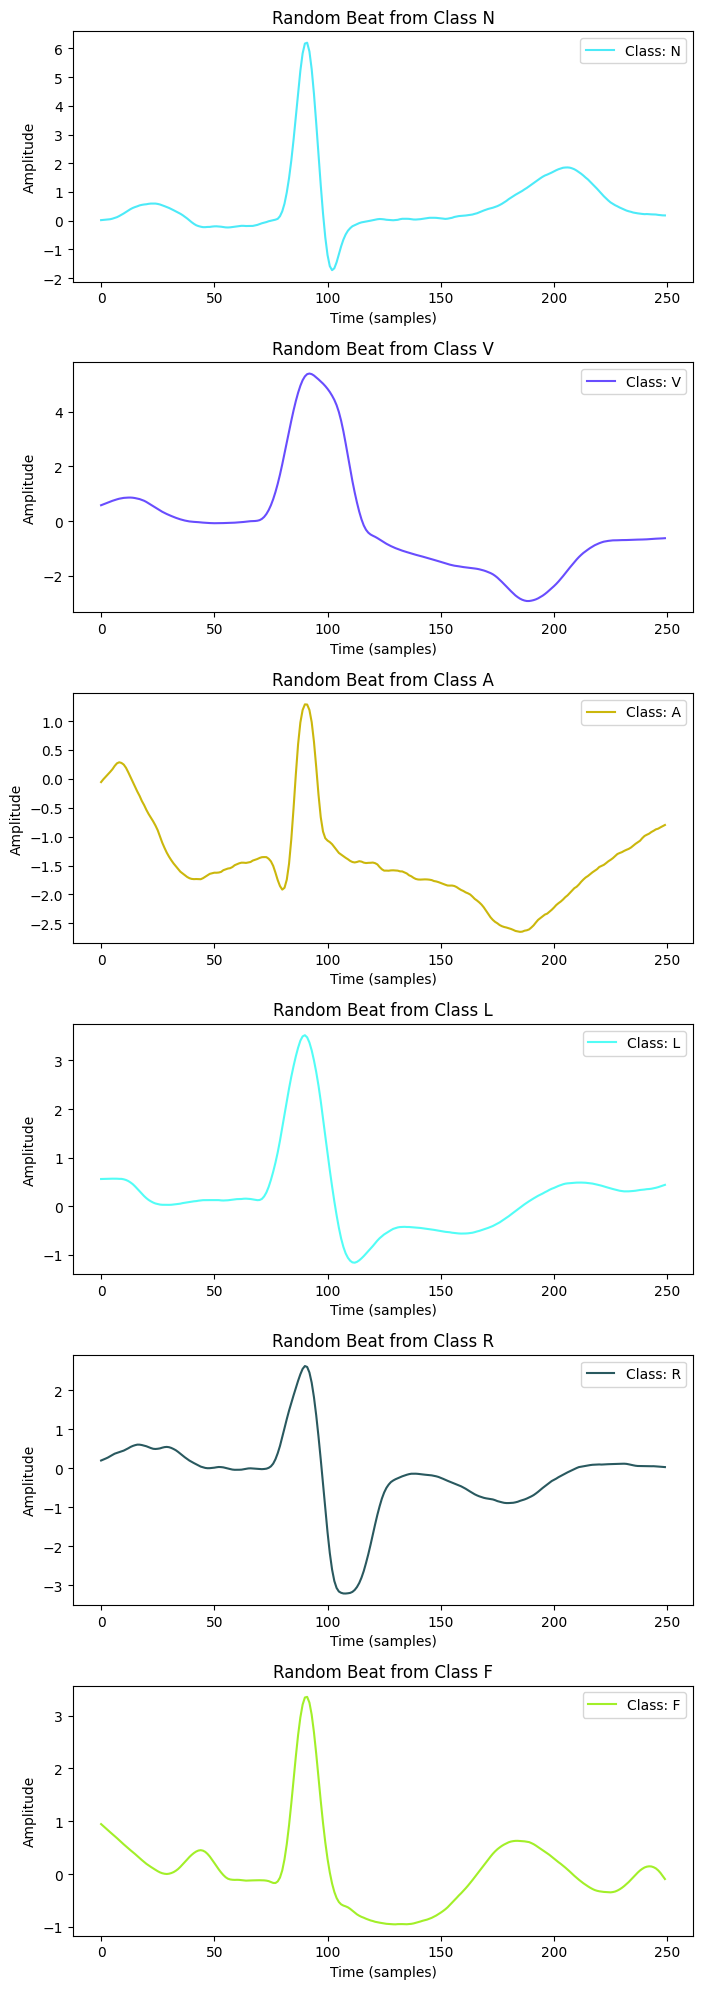

In [52]:
# Plot a random beat from each class
plt.figure(figsize=(7, 20))

for idx, cls in enumerate(classes):
    # Get all samples for the class
    class_indices = np.where(y_balanced == idx)[0]

    # Select a random beat from the class
    random_idx = random.choice(class_indices)
    random_beat = X_balanced[random_idx]

    # Plot the beat
    plt.subplot(len(classes), 1, idx + 1)
    plt.plot(random_beat, label=f"Class: {cls}", color=np.random.rand(3,))
    plt.title(f"Random Beat from Class {cls}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()

plt.tight_layout()
plt.show()


Train, Test & Validation splitting : 60, 20, 20

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
# First, split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=13, stratify=y_balanced)

# Then, split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13, stratify=y_temp)

# Print dataset shapes
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (18000, 250), (18000,)
Validation set: (6000, 250), (6000,)
Test set: (6000, 250), (6000,)


#Logistic Regression


Imports

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [ ]:
# Flatten ECG beats for Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Logistic Regression Pipeline with Scaling
logistic_model = Pipeline([
    ('scaler', StandardScaler()),  # Normalize input
    ('classifier', LogisticRegression(max_iter=5000, random_state=13))
])

# Train Model
logistic_model.fit(X_train_flat, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=5000, random_state=13))])

In [ ]:
# Predict on Test Data
y_pred = logistic_model.predict(X_test_flat)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 83.02%


In [ ]:
# Print classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

           N       0.70      0.74      0.72      1000
           V       0.81      0.78      0.79      1000
           A       0.87      0.79      0.83      1000
           L       0.82      0.87      0.84      1000
           R       0.92      0.95      0.93      1000
           F       0.88      0.85      0.86      1000

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



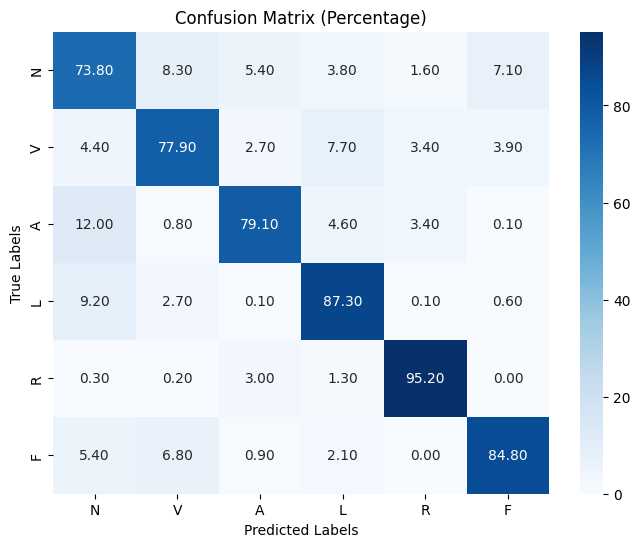

In [ ]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Convert to Percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentage)')
plt.show()


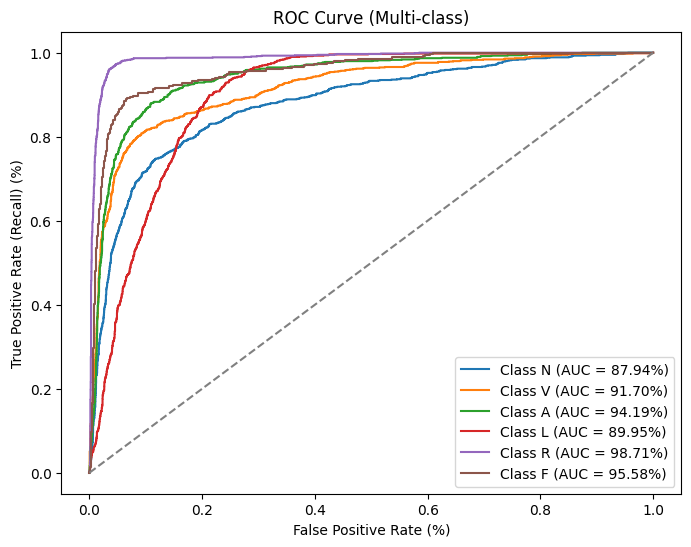

In [ ]:
# Binarize the labels for multi-class ROC computation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = logistic_model.decision_function(X_test_flat)

# Plot ROC Curve for Each Class
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr) * 100  # Convert AUC to percentage
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f}%)')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate (%)")
plt.ylabel("True Positive Rate (Recall) (%)")
plt.title("ROC Curve (Multi-class)")
plt.legend(loc="lower right")
plt.show()


#LSTM


In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
# Ensure data is in float32 format
X_train = np.array(X_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Reshape data to fit LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert labels to one-hot encoding
num_classes = 6  # Adjust based on your dataset
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)


In [57]:
def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build model
lstm_model = build_lstm_model((X_train.shape[1], 1), num_classes)
lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 250, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 250, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,950 (120.90 KB)

 Trainable params: 30,758 (120.15 KB)

 Non-trainable params: 192 (768.00 B)

In [60]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=32,
    verbose=1
)


Epoch 1/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.6938 - loss: 0.9110 - val_accuracy: 0.7167 - val_loss: 0.8275
Epoch 2/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7089 - loss: 0.8841 - val_accuracy: 0.7795 - val_loss: 0.6453
Epoch 3/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7555 - loss: 0.7580 - val_accuracy: 0.7528 - val_loss: 0.7482
Epoch 4/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7510 - loss: 0.7581 - val_accuracy: 0.8043 - val_loss: 0.5748
Epoch 5/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7771 - loss: 0.6978 - val_accuracy: 0.7460 - val_loss: 0.7513
Epoch 6/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7837 - loss: 0.6769 - val_accuracy: 0.7738 - val_loss: 0.6363
Epoch 7/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7909 - loss: 0.6476 - val_accuracy: 0.8062 - val_loss: 0.5719
Epoch 8/400
563/563 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.8074 - loss: 0

In [61]:
# Evaluate on test data
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Test Accuracy: 98.05%


In [62]:
# Predict classes
y_pred = np.argmax(lstm_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1000
           1       0.99      0.97      0.98      1000
           2       0.97      0.97      0.97      1000
           3       1.00      0.99      0.99      1000
           4       0.99      0.99      0.99      1000
           5       0.97      1.00      0.98      1000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000



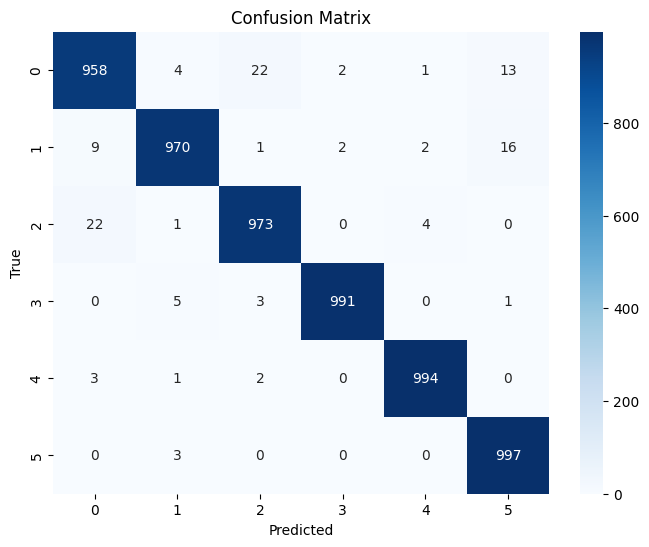

In [63]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


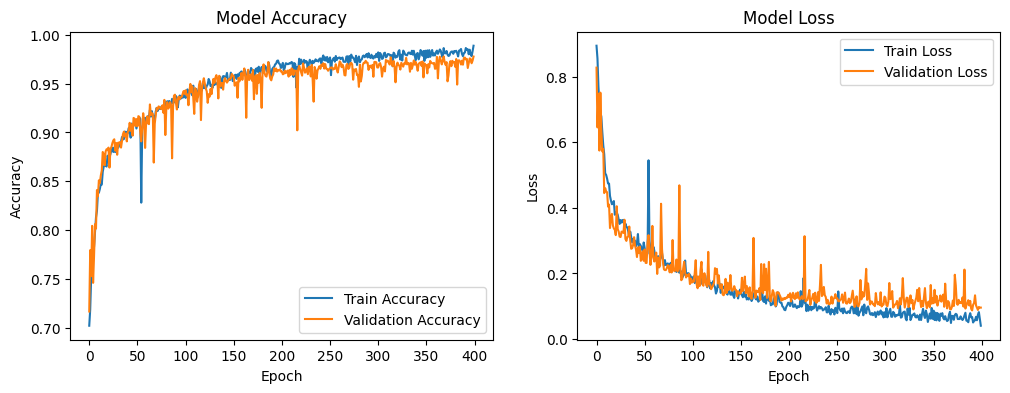

In [64]:
# Plot Accuracy & Loss Curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy Plot
ax[0].plot(history_lstm.history['accuracy'], label='Train Accuracy')
ax[0].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss Plot
ax[1].plot(history_lstm.history['loss'], label='Train Loss')
ax[1].plot(history_lstm.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()
